<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA6_Phase1/blob/main/EVA6_S7_Dilated_Albumentation_V6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Fri Jun 25 13:43:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!rm -rf ./*    # BEWARE : Removes all the files present in colab
#!rm -rf /content/sample_data

In [3]:
# Mounting the drive and copying the code from github to drive
from google.colab import drive 
drive.mount('/content/gdrive')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA6_Phase1

Mounted at /content/gdrive
Cloning into 'Deep_Learning_EVA6_Phase1'...
remote: Enumerating objects: 377, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 377 (delta 15), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (377/377), 9.20 MiB | 27.00 MiB/s, done.
Resolving deltas: 100% (189/189), done.


In [4]:
%cd Deep_Learning_EVA6_Phase1/src
! ls

/content/Deep_Learning_EVA6_Phase1/src
Alb_transforms.py  README.md	test_loss.py   utilities.py
models.py	   s7_model.py	train_loss.py


In [5]:
!pip install albumentations==1.0.0

     |████████████████████████████████| 102kB 7.0MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
cuda = torch.cuda.is_available()
print(f'Albumentations Version : {A.__version__}, Pytorch Version : {torch.__version__}, cuda:{cuda}')

Albumentations Version : 1.0.0, Pytorch Version : 1.9.0+cu102, cuda:True


In [8]:
# Import required src files
import s7_model, utilities, train_loss, test_loss, Alb_transforms

## Calculating mean & std-dev of CIFAR-10 train dataset. This is required for data augmentation

In [7]:
train = datasets.CIFAR10('./data', train=True, download=True)

n  = 0
s  = np.zeros(3)
sq = np.zeros(3)
i  = 0
batchsize = 128
for data, l in train:
  x   = np.array(data)/255                             # Image Normalization 
  s  += x.sum(axis=(0,1))                              # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))               # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n  += x.shape[0]*x.shape[1]                          # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i  += 1

batches = int(i/batchsize)
mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print(f'No: Of Train Images: {i}, Batch_size : {batchsize}, No: Of Batches:{batches}')
print(f'Channels Mean:{mu}, Channels Stdev:{std}, Total No: of pixels:{n}')


Extracting ./data/cifar-10-python.tar.gz to ./data
No: Of Train Images: 50000, Batch_size : 128, No: Of Batches:390
Channels Mean:[0.49139968 0.48215841 0.44653091], Channels Stdev:[0.24703223 0.24348513 0.26158784], Total No: of pixels:51200000


## Applying data augmentations to train and test dataset

In [10]:
if cuda:
    torch.cuda.manual_seed(1)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

channels_mean  = [0.49139968, 0.48215841, 0.44653091]
channels_stdev = [0.24703223, 0.24348513, 0.26158784]

test_transforms   = Alb_transforms.Alb_trans([A.Normalize(mean=channels_mean, std=channels_stdev),])
train_transforms  = Alb_transforms.Alb_trans([A.HorizontalFlip(),
                                              A.ShiftScaleRotate(),
                                              A.ToGray(),
                                              A.Normalize(mean=channels_mean, std=channels_stdev),
                                              A.CoarseDropout(max_holes=1, max_height=16, max_width=16,min_holes=1,
                                                              min_height=16,min_width=16,fill_value=channels_mean,mask_fill_value=None),
                                              ])

train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# train dataloader
trainloader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test_data, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


## Displaying train-data after applying augmentations. This is to get an idea how images looks like.

In [11]:
# Function to unnormalize and bring back to original pixel values. Transpose is to reshape the image on x & y axes and make it ready for display
def unnormalize(img):
    for i in range(img.shape[0]):
        img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
    img = img.permute(1, 2, 0)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape:torch.Size([128, 3, 32, 32]), labels.shape:torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


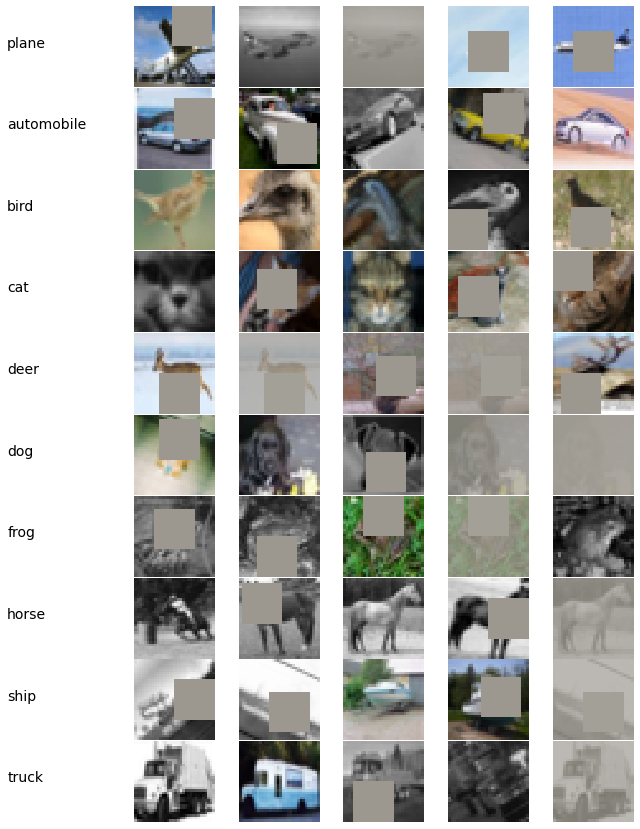

In [10]:
dataiter       = iter(trainloader)
images, labels = dataiter.next()
num_classes    = 10
print(f'images.shape:{images.shape}, labels.shape:{labels.shape}')
# display 5 images from each category. 
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

row, col   = 10, 8
num_images = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for class_num in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==class_num)[0], num_images)  ## Selecting 5 random images for each class
    ax  = plt.subplot(row, col,class_num*col + 1)                          ## Laying out space for display of a particular class
    ax.text(-0.1, 0.5, class_names[class_num], fontsize=14)                ## Displaying class names
    plt.axis('off')
    for j in range(1, num_images+1):                                       ## Displaying images one-by-one for a particular class
        plt.subplot(row, col, class_num*col+j+1)
        img = images[idx[j-1]]
        plt.imshow(unnormalize(img), interpolation='none')
        plt.axis('off')
plt.show()

# Model Params


In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [13]:
model = s7_model.S7_CNNModel_mixed().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,432
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]           1,152
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]           1,152
             ReLU-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 64, 32, 32]           1,152
             ReLU-14           [-1, 64,

In [13]:
print(model)

S7_CNNModel_mixed(
  (convblock0A): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock1A): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwise1A): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwise1B): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwise1C): Sequential(
    (0): Conv2d(64, 64, kernel_

# Training and Testing



In [14]:
def plot_misclassified(counters, num_images, title, class_names, fig_size):
    
    figure=plt.figure(figsize=fig_size)
    print(f'** Plotting misclassified test images from last epoch for {title} **')
    print('\n')
    class_names_dict = class_names
    if len(details['mis_img']) > num_images: 
        for i in range(num_images):
            plt.subplot(5,5,i+1)
            plt.axis(False)      
            #unnorm_img = unnorm_mispred.unnorm_albumented(test_stats.img[i].cpu())
            unnorm_img = unnormalize(counters['mis_img'][i].cpu())
            plt.imshow(unnorm_img, interpolation='none')
            prediction = class_names_dict.get(counters['mis_pred'][i])
            actual     = class_names_dict.get(counters['mis_lbl'][i])
            s="pred="+str(prediction)+" act="+str(actual)
            plt.text(2,-1,s)
    else:
        print(f"Unable to plot - Less than {num_images} images, only have {len(counters['mis_img'])} images")

In [15]:
def disp_details():
        
    print(f"Max train accuracy:{max(details['train_acc'])} out of {len(details['train_acc'])} epochs")
    print(f"Max test accuracy :{max(details['test_acc'])} out of {len(details['test_acc'])} epochs")

    print(f"Train accuracy: {details['train_acc'][-10:]}")
    print(f"Test accuracy : {details['test_acc'][-10:]}")

    figure = plt.figure(figsize=(12,8))

    plt.title(f"Train Losses")
    plt.plot(details['train_loss'])

    figure = plt.figure(figsize=(12,8))

    plt.title(f"Train Accuracy")
    plt.plot(details['train_acc'])

    figure = plt.figure(figsize=(12,8))

    plt.title(f"Test Losses")
    plt.plot(details['test_loss'])

    figure = plt.figure(figsize=(12,8))

    plt.title(f"Test Accuracy")
    plt.plot(details['test_acc'])

    class_names_dict = {0:'plane', 1:'automob', 2:'bird', 3:'cat',4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
    num_images       = 25
    fig_size         = (12, 12)
    title            = 'CIFAR-10'
    misclass_stats   = details
    plot_misclassified(misclass_stats, num_images, title, class_names_dict, fig_size)

In [16]:
from torch.optim.lr_scheduler import OneCycleLR

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.804897427558899 Batch_id=390 Train Accuracy=26.75: 100%|██████████| 391/391 [00:25<00:00, 15.34it/s]

Train set: Epoch : 0/250 Average loss: 0.0000, Train Accuracy: 26.75



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 0/250 Average loss: 1.5575, Test Accuracy: 41.5
EPOCH: 1


Loss=1.7785968780517578 Batch_id=390 Train Accuracy=37.83: 100%|██████████| 391/391 [00:25<00:00, 15.26it/s]

Train set: Epoch : 1/250 Average loss: 0.0000, Train Accuracy: 37.83



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 1/250 Average loss: 1.3907, Test Accuracy: 48.38
EPOCH: 2


Loss=1.6523833274841309 Batch_id=390 Train Accuracy=43.11: 100%|██████████| 391/391 [00:25<00:00, 15.14it/s]

Train set: Epoch : 2/250 Average loss: 0.0000, Train Accuracy: 43.11



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 2/250 Average loss: 1.2701, Test Accuracy: 53.45
EPOCH: 3


Loss=1.558996558189392 Batch_id=390 Train Accuracy=46.58: 100%|██████████| 391/391 [00:25<00:00, 15.15it/s]

Train set: Epoch : 3/250 Average loss: 0.0000, Train Accuracy: 46.58



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 3/250 Average loss: 1.2222, Test Accuracy: 54.84
EPOCH: 4


Loss=1.4207805395126343 Batch_id=390 Train Accuracy=49.66: 100%|██████████| 391/391 [00:25<00:00, 15.05it/s]

Train set: Epoch : 4/250 Average loss: 0.0000, Train Accuracy: 49.66



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 4/250 Average loss: 1.1208, Test Accuracy: 59.42
EPOCH: 5


Loss=1.2714461088180542 Batch_id=390 Train Accuracy=51.35: 100%|██████████| 391/391 [00:26<00:00, 14.91it/s]

Train set: Epoch : 5/250 Average loss: 0.0000, Train Accuracy: 51.35



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 5/250 Average loss: 1.0725, Test Accuracy: 61.55
EPOCH: 6


Loss=1.202673077583313 Batch_id=390 Train Accuracy=53.20: 100%|██████████| 391/391 [00:26<00:00, 14.75it/s]

Train set: Epoch : 6/250 Average loss: 0.0000, Train Accuracy: 53.2



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 6/250 Average loss: 1.0475, Test Accuracy: 63.17
EPOCH: 7


Loss=1.3001807928085327 Batch_id=390 Train Accuracy=54.82: 100%|██████████| 391/391 [00:26<00:00, 14.81it/s]

Train set: Epoch : 7/250 Average loss: 0.0000, Train Accuracy: 54.82



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 7/250 Average loss: 1.0086, Test Accuracy: 64.01
EPOCH: 8


Loss=1.2100013494491577 Batch_id=390 Train Accuracy=55.47: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s]

Train set: Epoch : 8/250 Average loss: 0.0000, Train Accuracy: 55.47



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 8/250 Average loss: 0.9944, Test Accuracy: 64.92
EPOCH: 9


Loss=1.2327983379364014 Batch_id=390 Train Accuracy=56.57: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s]

Train set: Epoch : 9/250 Average loss: 0.0000, Train Accuracy: 56.57



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 9/250 Average loss: 0.9495, Test Accuracy: 66.38
EPOCH: 10


Loss=1.2174068689346313 Batch_id=390 Train Accuracy=57.61: 100%|██████████| 391/391 [00:26<00:00, 14.69it/s]

Train set: Epoch : 10/250 Average loss: 0.0000, Train Accuracy: 57.61



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 10/250 Average loss: 0.8890, Test Accuracy: 68.6
EPOCH: 11


Loss=1.072344422340393 Batch_id=390 Train Accuracy=58.42: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s]

Train set: Epoch : 11/250 Average loss: 0.0000, Train Accuracy: 58.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 11/250 Average loss: 0.8977, Test Accuracy: 68.14
EPOCH: 12


Loss=1.1457189321517944 Batch_id=390 Train Accuracy=58.92: 100%|██████████| 391/391 [00:26<00:00, 14.77it/s]

Train set: Epoch : 12/250 Average loss: 0.0000, Train Accuracy: 58.92



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 12/250 Average loss: 0.8647, Test Accuracy: 69.28
EPOCH: 13


Loss=1.3245688676834106 Batch_id=390 Train Accuracy=59.73: 100%|██████████| 391/391 [00:26<00:00, 14.77it/s]

Train set: Epoch : 13/250 Average loss: 0.0000, Train Accuracy: 59.73



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 13/250 Average loss: 0.8725, Test Accuracy: 69.04
EPOCH: 14


Loss=1.2241290807724 Batch_id=390 Train Accuracy=60.37: 100%|██████████| 391/391 [00:26<00:00, 14.78it/s]

Train set: Epoch : 14/250 Average loss: 0.0000, Train Accuracy: 60.37



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 14/250 Average loss: 0.8414, Test Accuracy: 70.32
EPOCH: 15


Loss=1.1802654266357422 Batch_id=390 Train Accuracy=60.93: 100%|██████████| 391/391 [00:26<00:00, 14.80it/s]

Train set: Epoch : 15/250 Average loss: 0.0000, Train Accuracy: 60.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 15/250 Average loss: 0.8334, Test Accuracy: 71.03
EPOCH: 16


Loss=1.1293163299560547 Batch_id=390 Train Accuracy=61.52: 100%|██████████| 391/391 [00:26<00:00, 14.75it/s]

Train set: Epoch : 16/250 Average loss: 0.0000, Train Accuracy: 61.52



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 16/250 Average loss: 0.8349, Test Accuracy: 71.2
EPOCH: 17


Loss=1.1300561428070068 Batch_id=390 Train Accuracy=62.08: 100%|██████████| 391/391 [00:26<00:00, 14.70it/s]

Train set: Epoch : 17/250 Average loss: 0.0000, Train Accuracy: 62.08



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 17/250 Average loss: 0.8079, Test Accuracy: 72.2
EPOCH: 18


Loss=1.0991498231887817 Batch_id=390 Train Accuracy=62.69: 100%|██████████| 391/391 [00:26<00:00, 14.68it/s]

Train set: Epoch : 18/250 Average loss: 0.0000, Train Accuracy: 62.69



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 18/250 Average loss: 0.7902, Test Accuracy: 72.38
EPOCH: 19


Loss=0.9032278060913086 Batch_id=390 Train Accuracy=62.83: 100%|██████████| 391/391 [00:26<00:00, 14.68it/s]

Train set: Epoch : 19/250 Average loss: 0.0000, Train Accuracy: 62.83



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 19/250 Average loss: 0.7667, Test Accuracy: 73.26
EPOCH: 20


Loss=1.4572445154190063 Batch_id=390 Train Accuracy=63.34: 100%|██████████| 391/391 [00:26<00:00, 14.66it/s]

Train set: Epoch : 20/250 Average loss: 0.0000, Train Accuracy: 63.34



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 20/250 Average loss: 0.8001, Test Accuracy: 72.34
EPOCH: 21


Loss=0.8846190571784973 Batch_id=390 Train Accuracy=63.36: 100%|██████████| 391/391 [00:27<00:00, 14.46it/s]

Train set: Epoch : 21/250 Average loss: 0.0000, Train Accuracy: 63.36



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 21/250 Average loss: 0.7696, Test Accuracy: 73.08
EPOCH: 22


Loss=1.0435913801193237 Batch_id=390 Train Accuracy=63.85: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s]

Train set: Epoch : 22/250 Average loss: 0.0000, Train Accuracy: 63.85



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 22/250 Average loss: 0.7551, Test Accuracy: 73.91
EPOCH: 23


Loss=0.9132981896400452 Batch_id=390 Train Accuracy=64.27: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s]

Train set: Epoch : 23/250 Average loss: 0.0000, Train Accuracy: 64.27



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 23/250 Average loss: 0.7480, Test Accuracy: 74.11
EPOCH: 24


Loss=1.0547595024108887 Batch_id=390 Train Accuracy=64.59: 100%|██████████| 391/391 [00:26<00:00, 14.63it/s]

Train set: Epoch : 24/250 Average loss: 0.0000, Train Accuracy: 64.59



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 24/250 Average loss: 0.7326, Test Accuracy: 74.55
EPOCH: 25


Loss=1.058853030204773 Batch_id=390 Train Accuracy=64.89: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]

Train set: Epoch : 25/250 Average loss: 0.0000, Train Accuracy: 64.89



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 25/250 Average loss: 0.7324, Test Accuracy: 75.1
EPOCH: 26


Loss=0.970090389251709 Batch_id=390 Train Accuracy=64.96: 100%|██████████| 391/391 [00:27<00:00, 14.46it/s]

Train set: Epoch : 26/250 Average loss: 0.0000, Train Accuracy: 64.96



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 26/250 Average loss: 0.7159, Test Accuracy: 74.78
EPOCH: 27


Loss=1.0569988489151 Batch_id=390 Train Accuracy=65.17: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]

Train set: Epoch : 27/250 Average loss: 0.0000, Train Accuracy: 65.17



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 27/250 Average loss: 0.7051, Test Accuracy: 75.8
EPOCH: 28


Loss=1.3999027013778687 Batch_id=390 Train Accuracy=65.94: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s]

Train set: Epoch : 28/250 Average loss: 0.0000, Train Accuracy: 65.94



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 28/250 Average loss: 0.6834, Test Accuracy: 76.19
EPOCH: 29


Loss=0.9398968815803528 Batch_id=390 Train Accuracy=66.06: 100%|██████████| 391/391 [00:26<00:00, 14.56it/s]

Train set: Epoch : 29/250 Average loss: 0.0000, Train Accuracy: 66.06



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 29/250 Average loss: 0.6881, Test Accuracy: 76.09
EPOCH: 30


Loss=0.9299328327178955 Batch_id=390 Train Accuracy=65.92: 100%|██████████| 391/391 [00:26<00:00, 14.56it/s]

Train set: Epoch : 30/250 Average loss: 0.0000, Train Accuracy: 65.92



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 30/250 Average loss: 0.6742, Test Accuracy: 76.71
EPOCH: 31


Loss=1.1253517866134644 Batch_id=390 Train Accuracy=65.93: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s]

Train set: Epoch : 31/250 Average loss: 0.0000, Train Accuracy: 65.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 31/250 Average loss: 0.6732, Test Accuracy: 77.02
EPOCH: 32


Loss=0.8388543128967285 Batch_id=390 Train Accuracy=66.56: 100%|██████████| 391/391 [00:26<00:00, 14.60it/s]

Train set: Epoch : 32/250 Average loss: 0.0000, Train Accuracy: 66.56



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 32/250 Average loss: 0.6685, Test Accuracy: 77.09
EPOCH: 33


Loss=0.9596447348594666 Batch_id=390 Train Accuracy=66.81: 100%|██████████| 391/391 [00:26<00:00, 14.62it/s]

Train set: Epoch : 33/250 Average loss: 0.0000, Train Accuracy: 66.81



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 33/250 Average loss: 0.6737, Test Accuracy: 77.03
EPOCH: 34


Loss=1.0224733352661133 Batch_id=390 Train Accuracy=67.19: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s]

Train set: Epoch : 34/250 Average loss: 0.0000, Train Accuracy: 67.19



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 34/250 Average loss: 0.6900, Test Accuracy: 76.54
EPOCH: 35


Loss=0.9375050067901611 Batch_id=390 Train Accuracy=67.06: 100%|██████████| 391/391 [00:26<00:00, 14.63it/s]

Train set: Epoch : 35/250 Average loss: 0.0000, Train Accuracy: 67.06



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 35/250 Average loss: 0.6673, Test Accuracy: 77.41
EPOCH: 36


Loss=1.116701602935791 Batch_id=390 Train Accuracy=67.32: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s]

Train set: Epoch : 36/250 Average loss: 0.0000, Train Accuracy: 67.32



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 36/250 Average loss: 0.6448, Test Accuracy: 77.86
EPOCH: 37


Loss=0.8263033628463745 Batch_id=390 Train Accuracy=67.31: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]

Train set: Epoch : 37/250 Average loss: 0.0000, Train Accuracy: 67.31



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 37/250 Average loss: 0.6591, Test Accuracy: 77.11
EPOCH: 38


Loss=1.0107841491699219 Batch_id=390 Train Accuracy=67.87: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]

Train set: Epoch : 38/250 Average loss: 0.0000, Train Accuracy: 67.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 38/250 Average loss: 0.6504, Test Accuracy: 77.68
EPOCH: 39


Loss=0.9099494218826294 Batch_id=390 Train Accuracy=68.03: 100%|██████████| 391/391 [00:26<00:00, 14.63it/s]

Train set: Epoch : 39/250 Average loss: 0.0000, Train Accuracy: 68.03



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 39/250 Average loss: 0.6457, Test Accuracy: 78.14
EPOCH: 40


Loss=0.9259394407272339 Batch_id=390 Train Accuracy=68.07: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s]

Train set: Epoch : 40/250 Average loss: 0.0000, Train Accuracy: 68.07



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 40/250 Average loss: 0.6290, Test Accuracy: 78.58
EPOCH: 41


Loss=1.0003060102462769 Batch_id=390 Train Accuracy=68.44: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]

Train set: Epoch : 41/250 Average loss: 0.0000, Train Accuracy: 68.44



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 41/250 Average loss: 0.6524, Test Accuracy: 77.58
EPOCH: 42


Loss=0.8471307158470154 Batch_id=390 Train Accuracy=68.50: 100%|██████████| 391/391 [00:26<00:00, 14.55it/s]

Train set: Epoch : 42/250 Average loss: 0.0000, Train Accuracy: 68.5



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 42/250 Average loss: 0.6361, Test Accuracy: 77.9
EPOCH: 43


Loss=0.8028624057769775 Batch_id=390 Train Accuracy=68.65: 100%|██████████| 391/391 [00:26<00:00, 14.64it/s]

Train set: Epoch : 43/250 Average loss: 0.0000, Train Accuracy: 68.65



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 43/250 Average loss: 0.6502, Test Accuracy: 77.54
EPOCH: 44


Loss=0.9440125226974487 Batch_id=390 Train Accuracy=68.40: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s]

Train set: Epoch : 44/250 Average loss: 0.0000, Train Accuracy: 68.4



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 44/250 Average loss: 0.6460, Test Accuracy: 77.83
EPOCH: 45


Loss=0.9308095574378967 Batch_id=390 Train Accuracy=68.60: 100%|██████████| 391/391 [00:27<00:00, 14.48it/s]

Train set: Epoch : 45/250 Average loss: 0.0000, Train Accuracy: 68.6



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 45/250 Average loss: 0.6442, Test Accuracy: 77.44
EPOCH: 46


Loss=0.6571065187454224 Batch_id=390 Train Accuracy=68.85: 100%|██████████| 391/391 [00:26<00:00, 14.63it/s]

Train set: Epoch : 46/250 Average loss: 0.0000, Train Accuracy: 68.85



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 46/250 Average loss: 0.6257, Test Accuracy: 78.57
EPOCH: 47


Loss=0.883538007736206 Batch_id=390 Train Accuracy=69.18: 100%|██████████| 391/391 [00:26<00:00, 14.64it/s]

Train set: Epoch : 47/250 Average loss: 0.0000, Train Accuracy: 69.18



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 47/250 Average loss: 0.6622, Test Accuracy: 77.9
EPOCH: 48


Loss=0.9357807040214539 Batch_id=390 Train Accuracy=69.05: 100%|██████████| 391/391 [00:26<00:00, 14.56it/s]

Train set: Epoch : 48/250 Average loss: 0.0000, Train Accuracy: 69.05



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 48/250 Average loss: 0.5995, Test Accuracy: 79.59
EPOCH: 49


Loss=1.0274314880371094 Batch_id=390 Train Accuracy=69.27: 100%|██████████| 391/391 [00:26<00:00, 14.49it/s]

Train set: Epoch : 49/250 Average loss: 0.0000, Train Accuracy: 69.27



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 49/250 Average loss: 0.6220, Test Accuracy: 78.14
EPOCH: 50


Loss=1.1930044889450073 Batch_id=390 Train Accuracy=69.14: 100%|██████████| 391/391 [00:26<00:00, 14.51it/s]

Train set: Epoch : 50/250 Average loss: 0.0000, Train Accuracy: 69.14



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 50/250 Average loss: 0.5989, Test Accuracy: 79.39
EPOCH: 51


Loss=0.9262175559997559 Batch_id=390 Train Accuracy=69.80: 100%|██████████| 391/391 [00:26<00:00, 14.59it/s]

Train set: Epoch : 51/250 Average loss: 0.0000, Train Accuracy: 69.8



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 51/250 Average loss: 0.6046, Test Accuracy: 79.45
EPOCH: 52


Loss=1.2826228141784668 Batch_id=390 Train Accuracy=69.61: 100%|██████████| 391/391 [00:26<00:00, 14.52it/s]

Train set: Epoch : 52/250 Average loss: 0.0000, Train Accuracy: 69.61



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 52/250 Average loss: 0.5971, Test Accuracy: 79.53
EPOCH: 53


Loss=0.7013463973999023 Batch_id=390 Train Accuracy=69.53: 100%|██████████| 391/391 [00:26<00:00, 14.51it/s]

Train set: Epoch : 53/250 Average loss: 0.0000, Train Accuracy: 69.53



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 53/250 Average loss: 0.6003, Test Accuracy: 79.71
EPOCH: 54


Loss=0.9023489356040955 Batch_id=390 Train Accuracy=70.08: 100%|██████████| 391/391 [00:26<00:00, 14.62it/s]

Train set: Epoch : 54/250 Average loss: 0.0000, Train Accuracy: 70.08



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 54/250 Average loss: 0.5865, Test Accuracy: 79.8
EPOCH: 55


Loss=0.8316178917884827 Batch_id=390 Train Accuracy=69.93: 100%|██████████| 391/391 [00:27<00:00, 14.40it/s]

Train set: Epoch : 55/250 Average loss: 0.0000, Train Accuracy: 69.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 55/250 Average loss: 0.5847, Test Accuracy: 79.97
EPOCH: 56


Loss=0.9118468165397644 Batch_id=390 Train Accuracy=70.36: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]

Train set: Epoch : 56/250 Average loss: 0.0000, Train Accuracy: 70.36



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 56/250 Average loss: 0.5946, Test Accuracy: 79.61
EPOCH: 57


Loss=0.8063686490058899 Batch_id=390 Train Accuracy=70.28: 100%|██████████| 391/391 [00:26<00:00, 14.50it/s]

Train set: Epoch : 57/250 Average loss: 0.0000, Train Accuracy: 70.28



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 57/250 Average loss: 0.5921, Test Accuracy: 79.76
EPOCH: 58


Loss=0.9719586372375488 Batch_id=390 Train Accuracy=69.90: 100%|██████████| 391/391 [00:27<00:00, 14.48it/s]

Train set: Epoch : 58/250 Average loss: 0.0000, Train Accuracy: 69.9



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 58/250 Average loss: 0.5793, Test Accuracy: 80.25
EPOCH: 59


Loss=0.7520549297332764 Batch_id=390 Train Accuracy=70.31: 100%|██████████| 391/391 [00:26<00:00, 14.55it/s]

Train set: Epoch : 59/250 Average loss: 0.0000, Train Accuracy: 70.31



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 59/250 Average loss: 0.5833, Test Accuracy: 80.1
EPOCH: 60


Loss=0.9318908452987671 Batch_id=390 Train Accuracy=70.64: 100%|██████████| 391/391 [00:26<00:00, 14.49it/s]

Train set: Epoch : 60/250 Average loss: 0.0000, Train Accuracy: 70.64



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 60/250 Average loss: 0.5801, Test Accuracy: 80.36
EPOCH: 61


Loss=0.7121502757072449 Batch_id=390 Train Accuracy=70.70: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]

Train set: Epoch : 61/250 Average loss: 0.0000, Train Accuracy: 70.7



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 61/250 Average loss: 0.5829, Test Accuracy: 79.71
EPOCH: 62


Loss=0.7136277556419373 Batch_id=390 Train Accuracy=70.87: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s]

Train set: Epoch : 62/250 Average loss: 0.0000, Train Accuracy: 70.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 62/250 Average loss: 0.5618, Test Accuracy: 80.88
EPOCH: 63


Loss=0.6636021733283997 Batch_id=390 Train Accuracy=70.89: 100%|██████████| 391/391 [00:26<00:00, 14.49it/s]

Train set: Epoch : 63/250 Average loss: 0.0000, Train Accuracy: 70.89



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 63/250 Average loss: 0.5693, Test Accuracy: 80.4
EPOCH: 64


Loss=0.736304759979248 Batch_id=390 Train Accuracy=70.83: 100%|██████████| 391/391 [00:26<00:00, 14.50it/s]

Train set: Epoch : 64/250 Average loss: 0.0000, Train Accuracy: 70.83



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 64/250 Average loss: 0.5734, Test Accuracy: 80.44
EPOCH: 65


Loss=0.8277249336242676 Batch_id=390 Train Accuracy=71.07: 100%|██████████| 391/391 [00:27<00:00, 14.48it/s]

Train set: Epoch : 65/250 Average loss: 0.0000, Train Accuracy: 71.07



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 65/250 Average loss: 0.5585, Test Accuracy: 81.18
EPOCH: 66


Loss=0.7076869606971741 Batch_id=390 Train Accuracy=71.32: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]

Train set: Epoch : 66/250 Average loss: 0.0000, Train Accuracy: 71.32



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 66/250 Average loss: 0.5547, Test Accuracy: 81.36
EPOCH: 67


Loss=0.8722472190856934 Batch_id=390 Train Accuracy=71.04: 100%|██████████| 391/391 [00:27<00:00, 14.43it/s]

Train set: Epoch : 67/250 Average loss: 0.0000, Train Accuracy: 71.04



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 67/250 Average loss: 0.5588, Test Accuracy: 80.66
EPOCH: 68


Loss=0.8425400853157043 Batch_id=390 Train Accuracy=71.42: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

Train set: Epoch : 68/250 Average loss: 0.0000, Train Accuracy: 71.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 68/250 Average loss: 0.5540, Test Accuracy: 80.67
EPOCH: 69


Loss=0.8501817584037781 Batch_id=390 Train Accuracy=71.42: 100%|██████████| 391/391 [00:26<00:00, 14.50it/s]

Train set: Epoch : 69/250 Average loss: 0.0000, Train Accuracy: 71.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 69/250 Average loss: 0.5443, Test Accuracy: 81.23
EPOCH: 70


Loss=0.8361415863037109 Batch_id=390 Train Accuracy=71.63: 100%|██████████| 391/391 [00:26<00:00, 14.48it/s]

Train set: Epoch : 70/250 Average loss: 0.0000, Train Accuracy: 71.63



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 70/250 Average loss: 0.5503, Test Accuracy: 80.81
EPOCH: 71


Loss=0.7407968640327454 Batch_id=390 Train Accuracy=71.54: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]

Train set: Epoch : 71/250 Average loss: 0.0000, Train Accuracy: 71.54



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 71/250 Average loss: 0.5392, Test Accuracy: 81.19
EPOCH: 72


Loss=0.9194445013999939 Batch_id=390 Train Accuracy=71.63: 100%|██████████| 391/391 [00:27<00:00, 14.48it/s]

Train set: Epoch : 72/250 Average loss: 0.0000, Train Accuracy: 71.63



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 72/250 Average loss: 0.5450, Test Accuracy: 81.05
EPOCH: 73


Loss=0.7782115936279297 Batch_id=390 Train Accuracy=71.54: 100%|██████████| 391/391 [00:26<00:00, 14.50it/s]

Train set: Epoch : 73/250 Average loss: 0.0000, Train Accuracy: 71.54



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 73/250 Average loss: 0.5538, Test Accuracy: 80.8
EPOCH: 74


Loss=0.6710826754570007 Batch_id=390 Train Accuracy=71.63: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]

Train set: Epoch : 74/250 Average loss: 0.0000, Train Accuracy: 71.63



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 74/250 Average loss: 0.5619, Test Accuracy: 80.56
EPOCH: 75


Loss=0.8071128726005554 Batch_id=390 Train Accuracy=71.71: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s]

Train set: Epoch : 75/250 Average loss: 0.0000, Train Accuracy: 71.71



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 75/250 Average loss: 0.5288, Test Accuracy: 81.91
EPOCH: 76


Loss=1.0811585187911987 Batch_id=390 Train Accuracy=71.97: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

Train set: Epoch : 76/250 Average loss: 0.0000, Train Accuracy: 71.97



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 76/250 Average loss: 0.5408, Test Accuracy: 81.18
EPOCH: 77


Loss=0.946042001247406 Batch_id=390 Train Accuracy=71.69: 100%|██████████| 391/391 [00:26<00:00, 14.56it/s]

Train set: Epoch : 77/250 Average loss: 0.0000, Train Accuracy: 71.69



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 77/250 Average loss: 0.5264, Test Accuracy: 81.67
EPOCH: 78


Loss=0.739519476890564 Batch_id=390 Train Accuracy=72.08: 100%|██████████| 391/391 [00:27<00:00, 14.38it/s]

Train set: Epoch : 78/250 Average loss: 0.0000, Train Accuracy: 72.08



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 78/250 Average loss: 0.5331, Test Accuracy: 81.44
EPOCH: 79


Loss=0.906751811504364 Batch_id=390 Train Accuracy=71.99: 100%|██████████| 391/391 [00:27<00:00, 14.38it/s]

Train set: Epoch : 79/250 Average loss: 0.0000, Train Accuracy: 71.99



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 79/250 Average loss: 0.5379, Test Accuracy: 81.48
EPOCH: 80


Loss=0.6385505795478821 Batch_id=390 Train Accuracy=72.02: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 80/250 Average loss: 0.0000, Train Accuracy: 72.02



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 80/250 Average loss: 0.5327, Test Accuracy: 81.57
EPOCH: 81


Loss=1.1112467050552368 Batch_id=390 Train Accuracy=72.26: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

Train set: Epoch : 81/250 Average loss: 0.0000, Train Accuracy: 72.26



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 81/250 Average loss: 0.5395, Test Accuracy: 81.4
EPOCH: 82


Loss=0.9124488830566406 Batch_id=390 Train Accuracy=72.53: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 82/250 Average loss: 0.0000, Train Accuracy: 72.53



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 82/250 Average loss: 0.5297, Test Accuracy: 81.45
EPOCH: 83


Loss=0.5354356169700623 Batch_id=390 Train Accuracy=72.53: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 83/250 Average loss: 0.0000, Train Accuracy: 72.53



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 83/250 Average loss: 0.5319, Test Accuracy: 81.48
EPOCH: 84


Loss=0.7910271883010864 Batch_id=390 Train Accuracy=72.45: 100%|██████████| 391/391 [00:27<00:00, 14.46it/s]

Train set: Epoch : 84/250 Average loss: 0.0000, Train Accuracy: 72.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 84/250 Average loss: 0.5251, Test Accuracy: 81.74
EPOCH: 85


Loss=0.7968987822532654 Batch_id=390 Train Accuracy=72.42: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

Train set: Epoch : 85/250 Average loss: 0.0000, Train Accuracy: 72.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 85/250 Average loss: 0.5354, Test Accuracy: 81.57
EPOCH: 86


Loss=0.8740574717521667 Batch_id=390 Train Accuracy=72.55: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 86/250 Average loss: 0.0000, Train Accuracy: 72.55



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 86/250 Average loss: 0.5284, Test Accuracy: 82.27
EPOCH: 87


Loss=0.8198947310447693 Batch_id=390 Train Accuracy=72.50: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 87/250 Average loss: 0.0000, Train Accuracy: 72.5



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 87/250 Average loss: 0.5037, Test Accuracy: 82.99
EPOCH: 88


Loss=1.0409784317016602 Batch_id=390 Train Accuracy=72.60: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 88/250 Average loss: 0.0000, Train Accuracy: 72.6



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 88/250 Average loss: 0.5311, Test Accuracy: 81.68
EPOCH: 89


Loss=0.7623460292816162 Batch_id=390 Train Accuracy=72.84: 100%|██████████| 391/391 [00:27<00:00, 14.38it/s]

Train set: Epoch : 89/250 Average loss: 0.0000, Train Accuracy: 72.84



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 89/250 Average loss: 0.5160, Test Accuracy: 82.18
EPOCH: 90


Loss=0.9076017141342163 Batch_id=390 Train Accuracy=72.91: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s]

Train set: Epoch : 90/250 Average loss: 0.0000, Train Accuracy: 72.91



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 90/250 Average loss: 0.5201, Test Accuracy: 82.29
EPOCH: 91


Loss=1.0863569974899292 Batch_id=390 Train Accuracy=72.79: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 91/250 Average loss: 0.0000, Train Accuracy: 72.79



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 91/250 Average loss: 0.5216, Test Accuracy: 82.0
EPOCH: 92


Loss=0.6411495208740234 Batch_id=390 Train Accuracy=73.00: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]

Train set: Epoch : 92/250 Average loss: 0.0000, Train Accuracy: 73.0



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 92/250 Average loss: 0.5125, Test Accuracy: 82.81
EPOCH: 93


Loss=0.7540755271911621 Batch_id=390 Train Accuracy=72.78: 100%|██████████| 391/391 [00:27<00:00, 14.43it/s]

Train set: Epoch : 93/250 Average loss: 0.0000, Train Accuracy: 72.78



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 93/250 Average loss: 0.5111, Test Accuracy: 82.58
EPOCH: 94


Loss=0.8242784738540649 Batch_id=390 Train Accuracy=73.25: 100%|██████████| 391/391 [00:27<00:00, 14.39it/s]

Train set: Epoch : 94/250 Average loss: 0.0000, Train Accuracy: 73.25



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 94/250 Average loss: 0.5073, Test Accuracy: 82.8
EPOCH: 95


Loss=0.6744758486747742 Batch_id=390 Train Accuracy=73.10: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]

Train set: Epoch : 95/250 Average loss: 0.0000, Train Accuracy: 73.1



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 95/250 Average loss: 0.4961, Test Accuracy: 82.73
EPOCH: 96


Loss=0.7348974943161011 Batch_id=390 Train Accuracy=73.40: 100%|██████████| 391/391 [00:27<00:00, 14.44it/s]

Train set: Epoch : 96/250 Average loss: 0.0000, Train Accuracy: 73.4



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 96/250 Average loss: 0.5065, Test Accuracy: 82.85
EPOCH: 97


Loss=0.7103533148765564 Batch_id=390 Train Accuracy=73.16: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]

Train set: Epoch : 97/250 Average loss: 0.0000, Train Accuracy: 73.16



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 97/250 Average loss: 0.5196, Test Accuracy: 82.19
EPOCH: 98


Loss=0.8265475630760193 Batch_id=390 Train Accuracy=73.43: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s]

Train set: Epoch : 98/250 Average loss: 0.0000, Train Accuracy: 73.43



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 98/250 Average loss: 0.5044, Test Accuracy: 82.66
EPOCH: 99


Loss=0.7575609087944031 Batch_id=390 Train Accuracy=73.09: 100%|██████████| 391/391 [00:27<00:00, 14.39it/s]

Train set: Epoch : 99/250 Average loss: 0.0000, Train Accuracy: 73.09



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 99/250 Average loss: 0.4962, Test Accuracy: 83.12
EPOCH: 100


Loss=0.8581544756889343 Batch_id=390 Train Accuracy=73.55: 100%|██████████| 391/391 [00:27<00:00, 14.38it/s]

Train set: Epoch : 100/250 Average loss: 0.0000, Train Accuracy: 73.55



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 100/250 Average loss: 0.5113, Test Accuracy: 82.48
EPOCH: 101


Loss=0.7699947953224182 Batch_id=390 Train Accuracy=73.80: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 101/250 Average loss: 0.0000, Train Accuracy: 73.8



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 101/250 Average loss: 0.4974, Test Accuracy: 82.97
EPOCH: 102


Loss=0.9257645606994629 Batch_id=390 Train Accuracy=73.46: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 102/250 Average loss: 0.0000, Train Accuracy: 73.46



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 102/250 Average loss: 0.5007, Test Accuracy: 82.83
EPOCH: 103


Loss=0.7867577075958252 Batch_id=390 Train Accuracy=73.84: 100%|██████████| 391/391 [00:27<00:00, 14.39it/s]

Train set: Epoch : 103/250 Average loss: 0.0000, Train Accuracy: 73.84



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 103/250 Average loss: 0.4918, Test Accuracy: 82.84
EPOCH: 104


Loss=1.1141830682754517 Batch_id=390 Train Accuracy=73.79: 100%|██████████| 391/391 [00:27<00:00, 14.39it/s]

Train set: Epoch : 104/250 Average loss: 0.0000, Train Accuracy: 73.79



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 104/250 Average loss: 0.5033, Test Accuracy: 82.84
EPOCH: 105


Loss=0.7597336769104004 Batch_id=390 Train Accuracy=73.67: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s]

Train set: Epoch : 105/250 Average loss: 0.0000, Train Accuracy: 73.67



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 105/250 Average loss: 0.5048, Test Accuracy: 82.9
EPOCH: 106


Loss=0.7370809316635132 Batch_id=390 Train Accuracy=74.00: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]

Train set: Epoch : 106/250 Average loss: 0.0000, Train Accuracy: 74.0



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 106/250 Average loss: 0.5173, Test Accuracy: 81.94
EPOCH: 107


Loss=0.7312416434288025 Batch_id=390 Train Accuracy=73.91: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 107/250 Average loss: 0.0000, Train Accuracy: 73.91



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 107/250 Average loss: 0.4890, Test Accuracy: 83.17
EPOCH: 108


Loss=0.8033698797225952 Batch_id=390 Train Accuracy=73.68: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]

Train set: Epoch : 108/250 Average loss: 0.0000, Train Accuracy: 73.68



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 108/250 Average loss: 0.4920, Test Accuracy: 83.18
EPOCH: 109


Loss=0.9374151825904846 Batch_id=390 Train Accuracy=74.00: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]

Train set: Epoch : 109/250 Average loss: 0.0000, Train Accuracy: 74.0



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 109/250 Average loss: 0.4890, Test Accuracy: 83.54
EPOCH: 110


Loss=0.7282519936561584 Batch_id=390 Train Accuracy=73.90: 100%|██████████| 391/391 [00:27<00:00, 14.39it/s]

Train set: Epoch : 110/250 Average loss: 0.0000, Train Accuracy: 73.9



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 110/250 Average loss: 0.4989, Test Accuracy: 82.72
EPOCH: 111


Loss=0.8071713447570801 Batch_id=390 Train Accuracy=74.09: 100%|██████████| 391/391 [00:27<00:00, 14.32it/s]

Train set: Epoch : 111/250 Average loss: 0.0000, Train Accuracy: 74.09



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 111/250 Average loss: 0.4835, Test Accuracy: 83.43
EPOCH: 112


Loss=0.6607443690299988 Batch_id=390 Train Accuracy=73.81: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s]

Train set: Epoch : 112/250 Average loss: 0.0000, Train Accuracy: 73.81



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 112/250 Average loss: 0.4825, Test Accuracy: 83.31
EPOCH: 113


Loss=0.7977723479270935 Batch_id=390 Train Accuracy=74.11: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 113/250 Average loss: 0.0000, Train Accuracy: 74.11



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 113/250 Average loss: 0.4887, Test Accuracy: 83.01
EPOCH: 114


Loss=0.6858770847320557 Batch_id=390 Train Accuracy=74.22: 100%|██████████| 391/391 [00:27<00:00, 14.38it/s]

Train set: Epoch : 114/250 Average loss: 0.0000, Train Accuracy: 74.22



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 114/250 Average loss: 0.4853, Test Accuracy: 83.7
EPOCH: 115


Loss=0.4801006615161896 Batch_id=390 Train Accuracy=74.12: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]

Train set: Epoch : 115/250 Average loss: 0.0000, Train Accuracy: 74.12



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 115/250 Average loss: 0.4864, Test Accuracy: 83.4
EPOCH: 116


Loss=0.7586386203765869 Batch_id=390 Train Accuracy=74.10: 100%|██████████| 391/391 [00:27<00:00, 14.39it/s]

Train set: Epoch : 116/250 Average loss: 0.0000, Train Accuracy: 74.1



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 116/250 Average loss: 0.5021, Test Accuracy: 83.02
EPOCH: 117


Loss=0.8340683579444885 Batch_id=390 Train Accuracy=74.09: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 117/250 Average loss: 0.0000, Train Accuracy: 74.09



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 117/250 Average loss: 0.4952, Test Accuracy: 82.72
EPOCH: 118


Loss=0.6306557655334473 Batch_id=390 Train Accuracy=73.70: 100%|██████████| 391/391 [00:27<00:00, 14.34it/s]

Train set: Epoch : 118/250 Average loss: 0.0000, Train Accuracy: 73.7



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 118/250 Average loss: 0.4788, Test Accuracy: 83.79
EPOCH: 119


Loss=0.6442365050315857 Batch_id=390 Train Accuracy=74.42: 100%|██████████| 391/391 [00:27<00:00, 14.40it/s]

Train set: Epoch : 119/250 Average loss: 0.0000, Train Accuracy: 74.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 119/250 Average loss: 0.4783, Test Accuracy: 83.82
EPOCH: 120


Loss=0.693759560585022 Batch_id=390 Train Accuracy=74.41: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 120/250 Average loss: 0.0000, Train Accuracy: 74.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 120/250 Average loss: 0.4833, Test Accuracy: 83.44
EPOCH: 121


Loss=0.5455226302146912 Batch_id=390 Train Accuracy=74.20: 100%|██████████| 391/391 [00:27<00:00, 14.35it/s]

Train set: Epoch : 121/250 Average loss: 0.0000, Train Accuracy: 74.2



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 121/250 Average loss: 0.4962, Test Accuracy: 83.0
EPOCH: 122


Loss=0.6890231966972351 Batch_id=390 Train Accuracy=74.62: 100%|██████████| 391/391 [00:27<00:00, 14.40it/s]

Train set: Epoch : 122/250 Average loss: 0.0000, Train Accuracy: 74.62



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 122/250 Average loss: 0.4718, Test Accuracy: 84.12
EPOCH: 123


Loss=0.6546676754951477 Batch_id=390 Train Accuracy=74.65: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s]

Train set: Epoch : 123/250 Average loss: 0.0000, Train Accuracy: 74.65



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 123/250 Average loss: 0.4847, Test Accuracy: 83.39
EPOCH: 124


Loss=0.6312617659568787 Batch_id=390 Train Accuracy=74.21: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]

Train set: Epoch : 124/250 Average loss: 0.0000, Train Accuracy: 74.21



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 124/250 Average loss: 0.4695, Test Accuracy: 83.89
EPOCH: 125


Loss=0.885994017124176 Batch_id=390 Train Accuracy=74.42: 100%|██████████| 391/391 [00:27<00:00, 14.32it/s]

Train set: Epoch : 125/250 Average loss: 0.0000, Train Accuracy: 74.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 125/250 Average loss: 0.4735, Test Accuracy: 84.05
EPOCH: 126


Loss=0.837670624256134 Batch_id=390 Train Accuracy=74.64: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 126/250 Average loss: 0.0000, Train Accuracy: 74.64



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 126/250 Average loss: 0.4729, Test Accuracy: 83.69
EPOCH: 127


Loss=0.6142198443412781 Batch_id=390 Train Accuracy=74.75: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 127/250 Average loss: 0.0000, Train Accuracy: 74.75



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 127/250 Average loss: 0.4719, Test Accuracy: 84.1
EPOCH: 128


Loss=0.6773298978805542 Batch_id=390 Train Accuracy=74.84: 100%|██████████| 391/391 [00:27<00:00, 14.34it/s]

Train set: Epoch : 128/250 Average loss: 0.0000, Train Accuracy: 74.84



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 128/250 Average loss: 0.4656, Test Accuracy: 84.0
EPOCH: 129


Loss=0.884657621383667 Batch_id=390 Train Accuracy=74.72: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 129/250 Average loss: 0.0000, Train Accuracy: 74.72



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 129/250 Average loss: 0.4708, Test Accuracy: 83.96
EPOCH: 130


Loss=0.7452687621116638 Batch_id=390 Train Accuracy=74.91: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 130/250 Average loss: 0.0000, Train Accuracy: 74.91



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 130/250 Average loss: 0.4820, Test Accuracy: 83.5
EPOCH: 131


Loss=0.678310215473175 Batch_id=390 Train Accuracy=74.79: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 131/250 Average loss: 0.0000, Train Accuracy: 74.79



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 131/250 Average loss: 0.4675, Test Accuracy: 84.26
EPOCH: 132


Loss=0.7819269895553589 Batch_id=390 Train Accuracy=74.88: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 132/250 Average loss: 0.0000, Train Accuracy: 74.88



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 132/250 Average loss: 0.4667, Test Accuracy: 84.18
EPOCH: 133


Loss=1.0159369707107544 Batch_id=390 Train Accuracy=74.87: 100%|██████████| 391/391 [00:27<00:00, 14.32it/s]

Train set: Epoch : 133/250 Average loss: 0.0000, Train Accuracy: 74.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 133/250 Average loss: 0.4670, Test Accuracy: 83.93
EPOCH: 134


Loss=0.5442180037498474 Batch_id=390 Train Accuracy=74.88: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 134/250 Average loss: 0.0000, Train Accuracy: 74.88



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 134/250 Average loss: 0.4627, Test Accuracy: 84.25
EPOCH: 135


Loss=0.5721542239189148 Batch_id=390 Train Accuracy=74.62: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]

Train set: Epoch : 135/250 Average loss: 0.0000, Train Accuracy: 74.62



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 135/250 Average loss: 0.4796, Test Accuracy: 83.44
EPOCH: 136


Loss=0.7390528917312622 Batch_id=390 Train Accuracy=74.85: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 136/250 Average loss: 0.0000, Train Accuracy: 74.85



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 136/250 Average loss: 0.4682, Test Accuracy: 83.78
EPOCH: 137


Loss=0.6823716163635254 Batch_id=390 Train Accuracy=75.10: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 137/250 Average loss: 0.0000, Train Accuracy: 75.1



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 137/250 Average loss: 0.4667, Test Accuracy: 84.22
EPOCH: 138


Loss=0.7134315967559814 Batch_id=390 Train Accuracy=74.80: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 138/250 Average loss: 0.0000, Train Accuracy: 74.8



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 138/250 Average loss: 0.4591, Test Accuracy: 84.41
EPOCH: 139


Loss=0.4553426504135132 Batch_id=390 Train Accuracy=74.87: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]

Train set: Epoch : 139/250 Average loss: 0.0000, Train Accuracy: 74.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 139/250 Average loss: 0.4657, Test Accuracy: 84.32
EPOCH: 140


Loss=0.5974631905555725 Batch_id=390 Train Accuracy=75.24: 100%|██████████| 391/391 [00:27<00:00, 14.34it/s]

Train set: Epoch : 140/250 Average loss: 0.0000, Train Accuracy: 75.24



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 140/250 Average loss: 0.4700, Test Accuracy: 84.25
EPOCH: 141


Loss=0.8342981934547424 Batch_id=390 Train Accuracy=75.18: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 141/250 Average loss: 0.0000, Train Accuracy: 75.18



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 141/250 Average loss: 0.4495, Test Accuracy: 84.66
EPOCH: 142


Loss=0.6617952585220337 Batch_id=390 Train Accuracy=75.21: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 142/250 Average loss: 0.0000, Train Accuracy: 75.21



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 142/250 Average loss: 0.4581, Test Accuracy: 84.21
EPOCH: 143


Loss=0.5636105537414551 Batch_id=390 Train Accuracy=75.15: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 143/250 Average loss: 0.0000, Train Accuracy: 75.15



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 143/250 Average loss: 0.4771, Test Accuracy: 83.69
EPOCH: 144


Loss=0.413176029920578 Batch_id=390 Train Accuracy=75.48: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]

Train set: Epoch : 144/250 Average loss: 0.0000, Train Accuracy: 75.48



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 144/250 Average loss: 0.4622, Test Accuracy: 84.22
EPOCH: 145


Loss=0.7113848924636841 Batch_id=390 Train Accuracy=75.02: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 145/250 Average loss: 0.0000, Train Accuracy: 75.02



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 145/250 Average loss: 0.4635, Test Accuracy: 83.92
EPOCH: 146


Loss=0.5691938996315002 Batch_id=390 Train Accuracy=75.16: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 146/250 Average loss: 0.0000, Train Accuracy: 75.16



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 146/250 Average loss: 0.4633, Test Accuracy: 84.04
EPOCH: 147


Loss=0.7621931433677673 Batch_id=390 Train Accuracy=75.14: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 147/250 Average loss: 0.0000, Train Accuracy: 75.14



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 147/250 Average loss: 0.4544, Test Accuracy: 84.24
EPOCH: 148


Loss=0.5778102874755859 Batch_id=390 Train Accuracy=75.13: 100%|██████████| 391/391 [00:27<00:00, 14.41it/s]

Train set: Epoch : 148/250 Average loss: 0.0000, Train Accuracy: 75.13



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 148/250 Average loss: 0.4525, Test Accuracy: 84.4
EPOCH: 149


Loss=0.7904022336006165 Batch_id=390 Train Accuracy=75.49: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 149/250 Average loss: 0.0000, Train Accuracy: 75.49



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 149/250 Average loss: 0.4597, Test Accuracy: 84.32
EPOCH: 150


Loss=0.7599319219589233 Batch_id=390 Train Accuracy=75.64: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 150/250 Average loss: 0.0000, Train Accuracy: 75.64



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 150/250 Average loss: 0.4586, Test Accuracy: 83.94
EPOCH: 151


Loss=0.5847035646438599 Batch_id=390 Train Accuracy=75.40: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 151/250 Average loss: 0.0000, Train Accuracy: 75.4



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 151/250 Average loss: 0.4565, Test Accuracy: 84.25
EPOCH: 152


Loss=0.806186854839325 Batch_id=390 Train Accuracy=75.43: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 152/250 Average loss: 0.0000, Train Accuracy: 75.43



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 152/250 Average loss: 0.4497, Test Accuracy: 84.88
EPOCH: 153


Loss=0.6297305226325989 Batch_id=390 Train Accuracy=75.42: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 153/250 Average loss: 0.0000, Train Accuracy: 75.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 153/250 Average loss: 0.4557, Test Accuracy: 84.57
EPOCH: 154


Loss=0.9444127082824707 Batch_id=390 Train Accuracy=75.67: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 154/250 Average loss: 0.0000, Train Accuracy: 75.67



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 154/250 Average loss: 0.4477, Test Accuracy: 84.73
EPOCH: 155


Loss=0.6986303329467773 Batch_id=390 Train Accuracy=75.56: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 155/250 Average loss: 0.0000, Train Accuracy: 75.56



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 155/250 Average loss: 0.4556, Test Accuracy: 84.37
EPOCH: 156


Loss=0.7960585951805115 Batch_id=390 Train Accuracy=75.34: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 156/250 Average loss: 0.0000, Train Accuracy: 75.34



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 156/250 Average loss: 0.4587, Test Accuracy: 84.4
EPOCH: 157


Loss=0.46042710542678833 Batch_id=390 Train Accuracy=75.82: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 157/250 Average loss: 0.0000, Train Accuracy: 75.82



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 157/250 Average loss: 0.4595, Test Accuracy: 84.34
EPOCH: 158


Loss=0.7212778329849243 Batch_id=390 Train Accuracy=75.41: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 158/250 Average loss: 0.0000, Train Accuracy: 75.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 158/250 Average loss: 0.4543, Test Accuracy: 84.51
EPOCH: 159


Loss=0.7406038641929626 Batch_id=390 Train Accuracy=75.39: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 159/250 Average loss: 0.0000, Train Accuracy: 75.39



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 159/250 Average loss: 0.4508, Test Accuracy: 84.53
EPOCH: 160


Loss=0.6744380593299866 Batch_id=390 Train Accuracy=75.42: 100%|██████████| 391/391 [00:27<00:00, 14.29it/s]

Train set: Epoch : 160/250 Average loss: 0.0000, Train Accuracy: 75.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 160/250 Average loss: 0.4624, Test Accuracy: 84.36
EPOCH: 161


Loss=0.7520222067832947 Batch_id=390 Train Accuracy=75.67: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 161/250 Average loss: 0.0000, Train Accuracy: 75.67



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 161/250 Average loss: 0.4525, Test Accuracy: 84.69
EPOCH: 162


Loss=0.6506035923957825 Batch_id=390 Train Accuracy=75.86: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 162/250 Average loss: 0.0000, Train Accuracy: 75.86



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 162/250 Average loss: 0.4577, Test Accuracy: 84.41
EPOCH: 163


Loss=0.5864382386207581 Batch_id=390 Train Accuracy=76.04: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 163/250 Average loss: 0.0000, Train Accuracy: 76.04



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 163/250 Average loss: 0.4450, Test Accuracy: 84.53
EPOCH: 164


Loss=0.7350832223892212 Batch_id=390 Train Accuracy=75.54: 100%|██████████| 391/391 [00:27<00:00, 14.31it/s]

Train set: Epoch : 164/250 Average loss: 0.0000, Train Accuracy: 75.54



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 164/250 Average loss: 0.4616, Test Accuracy: 84.16
EPOCH: 165


Loss=0.7351696491241455 Batch_id=390 Train Accuracy=75.75: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 165/250 Average loss: 0.0000, Train Accuracy: 75.75



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 165/250 Average loss: 0.4491, Test Accuracy: 84.76
EPOCH: 166


Loss=0.8151024580001831 Batch_id=390 Train Accuracy=75.51: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 166/250 Average loss: 0.0000, Train Accuracy: 75.51



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 166/250 Average loss: 0.4488, Test Accuracy: 84.83
EPOCH: 167


Loss=0.6306158900260925 Batch_id=390 Train Accuracy=75.74: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 167/250 Average loss: 0.0000, Train Accuracy: 75.74



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 167/250 Average loss: 0.4425, Test Accuracy: 85.13
EPOCH: 168


Loss=0.7430211901664734 Batch_id=390 Train Accuracy=75.85: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s]

Train set: Epoch : 168/250 Average loss: 0.0000, Train Accuracy: 75.85



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 168/250 Average loss: 0.4430, Test Accuracy: 84.94
EPOCH: 169


Loss=0.5692585706710815 Batch_id=390 Train Accuracy=76.05: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 169/250 Average loss: 0.0000, Train Accuracy: 76.05



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 169/250 Average loss: 0.4593, Test Accuracy: 84.37
EPOCH: 170


Loss=0.896247148513794 Batch_id=390 Train Accuracy=75.83: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 170/250 Average loss: 0.0000, Train Accuracy: 75.83



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 170/250 Average loss: 0.4466, Test Accuracy: 84.78
EPOCH: 171


Loss=0.423225462436676 Batch_id=390 Train Accuracy=75.87: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 171/250 Average loss: 0.0000, Train Accuracy: 75.87



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 171/250 Average loss: 0.4460, Test Accuracy: 85.11
EPOCH: 172


Loss=0.6197258830070496 Batch_id=390 Train Accuracy=75.96: 100%|██████████| 391/391 [00:27<00:00, 14.28it/s]

Train set: Epoch : 172/250 Average loss: 0.0000, Train Accuracy: 75.96



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 172/250 Average loss: 0.4468, Test Accuracy: 84.64
EPOCH: 173


Loss=0.687525749206543 Batch_id=390 Train Accuracy=75.95: 100%|██████████| 391/391 [00:27<00:00, 14.27it/s]

Train set: Epoch : 173/250 Average loss: 0.0000, Train Accuracy: 75.95



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 173/250 Average loss: 0.4407, Test Accuracy: 85.04
EPOCH: 174


Loss=0.6431347131729126 Batch_id=390 Train Accuracy=75.88: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 174/250 Average loss: 0.0000, Train Accuracy: 75.88



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 174/250 Average loss: 0.4509, Test Accuracy: 84.79
EPOCH: 175


Loss=0.8251705169677734 Batch_id=390 Train Accuracy=76.04: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 175/250 Average loss: 0.0000, Train Accuracy: 76.04



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 175/250 Average loss: 0.4312, Test Accuracy: 85.45
EPOCH: 176


Loss=0.7632176280021667 Batch_id=390 Train Accuracy=76.20: 100%|██████████| 391/391 [00:27<00:00, 14.30it/s]

Train set: Epoch : 176/250 Average loss: 0.0000, Train Accuracy: 76.2



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 176/250 Average loss: 0.4398, Test Accuracy: 84.87
EPOCH: 177


Loss=0.84700608253479 Batch_id=390 Train Accuracy=75.97: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 177/250 Average loss: 0.0000, Train Accuracy: 75.97



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 177/250 Average loss: 0.4450, Test Accuracy: 84.74
EPOCH: 178


Loss=0.6706523299217224 Batch_id=390 Train Accuracy=76.15: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 178/250 Average loss: 0.0000, Train Accuracy: 76.15



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 178/250 Average loss: 0.4423, Test Accuracy: 84.83
EPOCH: 179


Loss=0.7054709196090698 Batch_id=390 Train Accuracy=76.26: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 179/250 Average loss: 0.0000, Train Accuracy: 76.26



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 179/250 Average loss: 0.4380, Test Accuracy: 84.99
EPOCH: 180


Loss=0.7666833400726318 Batch_id=390 Train Accuracy=76.45: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 180/250 Average loss: 0.0000, Train Accuracy: 76.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 180/250 Average loss: 0.4419, Test Accuracy: 84.89
EPOCH: 181


Loss=0.6439489126205444 Batch_id=390 Train Accuracy=76.27: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 181/250 Average loss: 0.0000, Train Accuracy: 76.27



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 181/250 Average loss: 0.4444, Test Accuracy: 84.81
EPOCH: 182


Loss=0.6561144590377808 Batch_id=390 Train Accuracy=76.10: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 182/250 Average loss: 0.0000, Train Accuracy: 76.1



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 182/250 Average loss: 0.4430, Test Accuracy: 84.77
EPOCH: 183


Loss=0.8044605851173401 Batch_id=390 Train Accuracy=76.42: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]

Train set: Epoch : 183/250 Average loss: 0.0000, Train Accuracy: 76.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 183/250 Average loss: 0.4448, Test Accuracy: 84.56
EPOCH: 184


Loss=0.9808054566383362 Batch_id=390 Train Accuracy=76.28: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 184/250 Average loss: 0.0000, Train Accuracy: 76.28



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 184/250 Average loss: 0.4546, Test Accuracy: 84.56
EPOCH: 185


Loss=0.800990641117096 Batch_id=390 Train Accuracy=76.52: 100%|██████████| 391/391 [00:27<00:00, 14.25it/s]

Train set: Epoch : 185/250 Average loss: 0.0000, Train Accuracy: 76.52



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 185/250 Average loss: 0.4444, Test Accuracy: 85.18
EPOCH: 186


Loss=0.9881346821784973 Batch_id=390 Train Accuracy=76.45: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 186/250 Average loss: 0.0000, Train Accuracy: 76.45



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 186/250 Average loss: 0.4402, Test Accuracy: 85.17
EPOCH: 187


Loss=0.7438812851905823 Batch_id=390 Train Accuracy=76.36: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 187/250 Average loss: 0.0000, Train Accuracy: 76.36



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 187/250 Average loss: 0.4350, Test Accuracy: 85.03
EPOCH: 188


Loss=0.5059888958930969 Batch_id=390 Train Accuracy=76.27: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 188/250 Average loss: 0.0000, Train Accuracy: 76.27



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 188/250 Average loss: 0.4365, Test Accuracy: 84.97
EPOCH: 189


Loss=0.5436952114105225 Batch_id=390 Train Accuracy=76.41: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]

Train set: Epoch : 189/250 Average loss: 0.0000, Train Accuracy: 76.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 189/250 Average loss: 0.4432, Test Accuracy: 84.71
EPOCH: 190


Loss=1.0398871898651123 Batch_id=390 Train Accuracy=76.36: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 190/250 Average loss: 0.0000, Train Accuracy: 76.36



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 190/250 Average loss: 0.4301, Test Accuracy: 85.43
EPOCH: 191


Loss=0.7492914795875549 Batch_id=390 Train Accuracy=76.35: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 191/250 Average loss: 0.0000, Train Accuracy: 76.35



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 191/250 Average loss: 0.4312, Test Accuracy: 85.2
EPOCH: 192


Loss=1.0211379528045654 Batch_id=390 Train Accuracy=76.46: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 192/250 Average loss: 0.0000, Train Accuracy: 76.46



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 192/250 Average loss: 0.4531, Test Accuracy: 84.58
EPOCH: 193


Loss=0.8070992827415466 Batch_id=390 Train Accuracy=76.41: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 193/250 Average loss: 0.0000, Train Accuracy: 76.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 193/250 Average loss: 0.4505, Test Accuracy: 84.62
EPOCH: 194


Loss=0.7872334122657776 Batch_id=390 Train Accuracy=76.43: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]

Train set: Epoch : 194/250 Average loss: 0.0000, Train Accuracy: 76.43



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 194/250 Average loss: 0.4335, Test Accuracy: 85.28
EPOCH: 195


Loss=0.6469303965568542 Batch_id=390 Train Accuracy=76.81: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 195/250 Average loss: 0.0000, Train Accuracy: 76.81



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 195/250 Average loss: 0.4434, Test Accuracy: 84.98
EPOCH: 196


Loss=0.7958055734634399 Batch_id=390 Train Accuracy=76.43: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 196/250 Average loss: 0.0000, Train Accuracy: 76.43



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 196/250 Average loss: 0.4301, Test Accuracy: 85.31
EPOCH: 197


Loss=0.5825996994972229 Batch_id=390 Train Accuracy=76.91: 100%|██████████| 391/391 [00:27<00:00, 14.24it/s]

Train set: Epoch : 197/250 Average loss: 0.0000, Train Accuracy: 76.91



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 197/250 Average loss: 0.4434, Test Accuracy: 85.06
EPOCH: 198


Loss=0.7245472073554993 Batch_id=390 Train Accuracy=76.21: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]

Train set: Epoch : 198/250 Average loss: 0.0000, Train Accuracy: 76.21



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 198/250 Average loss: 0.4315, Test Accuracy: 85.21
EPOCH: 199


Loss=0.80162513256073 Batch_id=390 Train Accuracy=76.58: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 199/250 Average loss: 0.0000, Train Accuracy: 76.58



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 199/250 Average loss: 0.4510, Test Accuracy: 84.51
EPOCH: 200


Loss=0.6732917428016663 Batch_id=390 Train Accuracy=76.56: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 200/250 Average loss: 0.0000, Train Accuracy: 76.56



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 200/250 Average loss: 0.4442, Test Accuracy: 84.84
EPOCH: 201


Loss=0.5308406352996826 Batch_id=390 Train Accuracy=76.59: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 201/250 Average loss: 0.0000, Train Accuracy: 76.59



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 201/250 Average loss: 0.4251, Test Accuracy: 85.31
EPOCH: 202


Loss=0.5842096209526062 Batch_id=390 Train Accuracy=76.94: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 202/250 Average loss: 0.0000, Train Accuracy: 76.94



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 202/250 Average loss: 0.4476, Test Accuracy: 84.98
EPOCH: 203


Loss=0.36453869938850403 Batch_id=390 Train Accuracy=76.99: 100%|██████████| 391/391 [00:27<00:00, 14.17it/s]

Train set: Epoch : 203/250 Average loss: 0.0000, Train Accuracy: 76.99



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 203/250 Average loss: 0.4283, Test Accuracy: 85.17
EPOCH: 204


Loss=0.8968491554260254 Batch_id=390 Train Accuracy=77.02: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 204/250 Average loss: 0.0000, Train Accuracy: 77.02



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 204/250 Average loss: 0.4345, Test Accuracy: 85.38
EPOCH: 205


Loss=0.6311495900154114 Batch_id=390 Train Accuracy=76.54: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]

Train set: Epoch : 205/250 Average loss: 0.0000, Train Accuracy: 76.54



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 205/250 Average loss: 0.4303, Test Accuracy: 85.61
EPOCH: 206


Loss=0.7260620594024658 Batch_id=390 Train Accuracy=76.71: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 206/250 Average loss: 0.0000, Train Accuracy: 76.71



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 206/250 Average loss: 0.4453, Test Accuracy: 84.9
EPOCH: 207


Loss=0.6878314018249512 Batch_id=390 Train Accuracy=76.79: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 207/250 Average loss: 0.0000, Train Accuracy: 76.79



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 207/250 Average loss: 0.4417, Test Accuracy: 84.97
EPOCH: 208


Loss=0.6940957903862 Batch_id=390 Train Accuracy=76.78: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 208/250 Average loss: 0.0000, Train Accuracy: 76.78



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 208/250 Average loss: 0.4356, Test Accuracy: 85.34
EPOCH: 209


Loss=0.8176361322402954 Batch_id=390 Train Accuracy=76.82: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 209/250 Average loss: 0.0000, Train Accuracy: 76.82



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 209/250 Average loss: 0.4390, Test Accuracy: 85.02
EPOCH: 210


Loss=0.8096915483474731 Batch_id=390 Train Accuracy=76.57: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 210/250 Average loss: 0.0000, Train Accuracy: 76.57



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 210/250 Average loss: 0.4443, Test Accuracy: 84.96
EPOCH: 211


Loss=0.8745355010032654 Batch_id=390 Train Accuracy=76.93: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 211/250 Average loss: 0.0000, Train Accuracy: 76.93



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 211/250 Average loss: 0.4326, Test Accuracy: 85.17
EPOCH: 212


Loss=0.8106492757797241 Batch_id=390 Train Accuracy=77.02: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]

Train set: Epoch : 212/250 Average loss: 0.0000, Train Accuracy: 77.02



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 212/250 Average loss: 0.4285, Test Accuracy: 85.44
EPOCH: 213


Loss=0.9418434500694275 Batch_id=390 Train Accuracy=76.89: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 213/250 Average loss: 0.0000, Train Accuracy: 76.89



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 213/250 Average loss: 0.4324, Test Accuracy: 85.09
EPOCH: 214


Loss=0.8135785460472107 Batch_id=390 Train Accuracy=76.74: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 214/250 Average loss: 0.0000, Train Accuracy: 76.74



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 214/250 Average loss: 0.4361, Test Accuracy: 85.23
EPOCH: 215


Loss=0.7231835722923279 Batch_id=390 Train Accuracy=76.96: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 215/250 Average loss: 0.0000, Train Accuracy: 76.96



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 215/250 Average loss: 0.4343, Test Accuracy: 85.32
EPOCH: 216


Loss=0.83213871717453 Batch_id=390 Train Accuracy=76.91: 100%|██████████| 391/391 [00:27<00:00, 14.19it/s]

Train set: Epoch : 216/250 Average loss: 0.0000, Train Accuracy: 76.91



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 216/250 Average loss: 0.4354, Test Accuracy: 85.25
EPOCH: 217


Loss=0.7756611108779907 Batch_id=390 Train Accuracy=77.10: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 217/250 Average loss: 0.0000, Train Accuracy: 77.1



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 217/250 Average loss: 0.4300, Test Accuracy: 85.4
EPOCH: 218


Loss=0.7964824438095093 Batch_id=390 Train Accuracy=77.09: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 218/250 Average loss: 0.0000, Train Accuracy: 77.09



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 218/250 Average loss: 0.4252, Test Accuracy: 85.37
EPOCH: 219


Loss=0.8325502276420593 Batch_id=390 Train Accuracy=77.02: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 219/250 Average loss: 0.0000, Train Accuracy: 77.02



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 219/250 Average loss: 0.4252, Test Accuracy: 85.7
EPOCH: 220


Loss=0.6173664331436157 Batch_id=390 Train Accuracy=77.04: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 220/250 Average loss: 0.0000, Train Accuracy: 77.04



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 220/250 Average loss: 0.4278, Test Accuracy: 85.53
EPOCH: 221


Loss=0.5525752902030945 Batch_id=390 Train Accuracy=77.19: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 221/250 Average loss: 0.0000, Train Accuracy: 77.19



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 221/250 Average loss: 0.4284, Test Accuracy: 85.35
EPOCH: 222


Loss=0.7228146195411682 Batch_id=390 Train Accuracy=77.08: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]

Train set: Epoch : 222/250 Average loss: 0.0000, Train Accuracy: 77.08



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 222/250 Average loss: 0.4465, Test Accuracy: 84.55
EPOCH: 223


Loss=0.5164421200752258 Batch_id=390 Train Accuracy=76.86: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 223/250 Average loss: 0.0000, Train Accuracy: 76.86



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 223/250 Average loss: 0.4349, Test Accuracy: 85.61
EPOCH: 224


Loss=0.6403900384902954 Batch_id=390 Train Accuracy=77.05: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 224/250 Average loss: 0.0000, Train Accuracy: 77.05



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 224/250 Average loss: 0.4371, Test Accuracy: 85.53
EPOCH: 225


Loss=0.5828679800033569 Batch_id=390 Train Accuracy=77.24: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 225/250 Average loss: 0.0000, Train Accuracy: 77.24



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 225/250 Average loss: 0.4340, Test Accuracy: 85.39
EPOCH: 226


Loss=0.7727808952331543 Batch_id=390 Train Accuracy=77.14: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s]

Train set: Epoch : 226/250 Average loss: 0.0000, Train Accuracy: 77.14



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 226/250 Average loss: 0.4310, Test Accuracy: 85.65
EPOCH: 227


Loss=0.707798957824707 Batch_id=390 Train Accuracy=77.08: 100%|██████████| 391/391 [00:27<00:00, 14.11it/s]

Train set: Epoch : 227/250 Average loss: 0.0000, Train Accuracy: 77.08



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 227/250 Average loss: 0.4206, Test Accuracy: 85.65
EPOCH: 228


Loss=0.6258800029754639 Batch_id=390 Train Accuracy=77.12: 100%|██████████| 391/391 [00:27<00:00, 14.09it/s]

Train set: Epoch : 228/250 Average loss: 0.0000, Train Accuracy: 77.12



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 228/250 Average loss: 0.4299, Test Accuracy: 85.16
EPOCH: 229


Loss=0.7221352458000183 Batch_id=390 Train Accuracy=77.18: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s]

Train set: Epoch : 229/250 Average loss: 0.0000, Train Accuracy: 77.18



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 229/250 Average loss: 0.4247, Test Accuracy: 85.64
EPOCH: 230


Loss=0.5893107652664185 Batch_id=390 Train Accuracy=77.16: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 230/250 Average loss: 0.0000, Train Accuracy: 77.16



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 230/250 Average loss: 0.4220, Test Accuracy: 85.69
EPOCH: 231


Loss=0.6576687693595886 Batch_id=390 Train Accuracy=77.19: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 231/250 Average loss: 0.0000, Train Accuracy: 77.19



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 231/250 Average loss: 0.4240, Test Accuracy: 85.52
EPOCH: 232


Loss=0.6080896258354187 Batch_id=390 Train Accuracy=77.25: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 232/250 Average loss: 0.0000, Train Accuracy: 77.25



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 232/250 Average loss: 0.4159, Test Accuracy: 85.8
EPOCH: 233


Loss=0.6135066747665405 Batch_id=390 Train Accuracy=77.27: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]

Train set: Epoch : 233/250 Average loss: 0.0000, Train Accuracy: 77.27



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 233/250 Average loss: 0.4328, Test Accuracy: 85.4
EPOCH: 234


Loss=0.4608116149902344 Batch_id=390 Train Accuracy=77.36: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]

Train set: Epoch : 234/250 Average loss: 0.0000, Train Accuracy: 77.36



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 234/250 Average loss: 0.4198, Test Accuracy: 86.23
EPOCH: 235


Loss=0.7909132838249207 Batch_id=390 Train Accuracy=77.13: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 235/250 Average loss: 0.0000, Train Accuracy: 77.13



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 235/250 Average loss: 0.4332, Test Accuracy: 85.68
EPOCH: 236


Loss=0.733666181564331 Batch_id=390 Train Accuracy=77.41: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]

Train set: Epoch : 236/250 Average loss: 0.0000, Train Accuracy: 77.41



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 236/250 Average loss: 0.4300, Test Accuracy: 85.7
EPOCH: 237


Loss=0.47394394874572754 Batch_id=390 Train Accuracy=77.19: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s]

Train set: Epoch : 237/250 Average loss: 0.0000, Train Accuracy: 77.19



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 237/250 Average loss: 0.4292, Test Accuracy: 85.59
EPOCH: 238


Loss=0.6606667637825012 Batch_id=390 Train Accuracy=77.31: 100%|██████████| 391/391 [00:27<00:00, 14.18it/s]

Train set: Epoch : 238/250 Average loss: 0.0000, Train Accuracy: 77.31



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 238/250 Average loss: 0.4238, Test Accuracy: 85.91
EPOCH: 239


Loss=0.7451896071434021 Batch_id=390 Train Accuracy=77.19: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]

Train set: Epoch : 239/250 Average loss: 0.0000, Train Accuracy: 77.19



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 239/250 Average loss: 0.4217, Test Accuracy: 85.83
EPOCH: 240


Loss=0.6335299611091614 Batch_id=390 Train Accuracy=77.32: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]

Train set: Epoch : 240/250 Average loss: 0.0000, Train Accuracy: 77.32



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 240/250 Average loss: 0.4252, Test Accuracy: 85.71
EPOCH: 241


Loss=0.7544848322868347 Batch_id=390 Train Accuracy=77.31: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 241/250 Average loss: 0.0000, Train Accuracy: 77.31



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 241/250 Average loss: 0.4229, Test Accuracy: 85.7
EPOCH: 242


Loss=0.5323121547698975 Batch_id=390 Train Accuracy=77.59: 100%|██████████| 391/391 [00:27<00:00, 13.98it/s]

Train set: Epoch : 242/250 Average loss: 0.0000, Train Accuracy: 77.59



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 242/250 Average loss: 0.4198, Test Accuracy: 85.97
EPOCH: 243


Loss=0.6655271649360657 Batch_id=390 Train Accuracy=77.38: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 243/250 Average loss: 0.0000, Train Accuracy: 77.38



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 243/250 Average loss: 0.4258, Test Accuracy: 85.63
EPOCH: 244


Loss=0.6459437608718872 Batch_id=390 Train Accuracy=77.09: 100%|██████████| 391/391 [00:27<00:00, 14.10it/s]

Train set: Epoch : 244/250 Average loss: 0.0000, Train Accuracy: 77.09



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 244/250 Average loss: 0.4238, Test Accuracy: 85.51
EPOCH: 245


Loss=0.7849346399307251 Batch_id=390 Train Accuracy=77.32: 100%|██████████| 391/391 [00:28<00:00, 13.94it/s]

Train set: Epoch : 245/250 Average loss: 0.0000, Train Accuracy: 77.32



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 245/250 Average loss: 0.4211, Test Accuracy: 86.2
EPOCH: 246


Loss=0.7231239676475525 Batch_id=390 Train Accuracy=77.42: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 246/250 Average loss: 0.0000, Train Accuracy: 77.42



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 246/250 Average loss: 0.4310, Test Accuracy: 85.55
EPOCH: 247


Loss=0.7085943818092346 Batch_id=390 Train Accuracy=77.53: 100%|██████████| 391/391 [00:27<00:00, 14.07it/s]

Train set: Epoch : 247/250 Average loss: 0.0000, Train Accuracy: 77.53



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 247/250 Average loss: 0.4214, Test Accuracy: 85.66
EPOCH: 248


Loss=0.6892397403717041 Batch_id=390 Train Accuracy=77.15: 100%|██████████| 391/391 [00:27<00:00, 14.06it/s]

Train set: Epoch : 248/250 Average loss: 0.0000, Train Accuracy: 77.15



  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Epoch : 248/250 Average loss: 0.4349, Test Accuracy: 85.26
EPOCH: 249


Loss=0.5431192517280579 Batch_id=390 Train Accuracy=77.62: 100%|██████████| 391/391 [00:28<00:00, 13.95it/s]

Train set: Epoch : 249/250 Average loss: 0.0000, Train Accuracy: 77.62



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test set: Epoch : 249/250 Average loss: 0.4328, Test Accuracy: 85.33
Max train accuracy:77.62 out of 250 epochs
Max test accuracy :86.23 out of 250 epochs
Train accuracy: [77.32, 77.31, 77.59, 77.38, 77.09, 77.32, 77.42, 77.53, 77.15, 77.62]
Test accuracy : [85.71, 85.7, 85.97, 85.63, 85.51, 86.2, 85.55, 85.66, 85.26, 85.33]
** Plotting misclassified test images from last epoch for CIFAR-10 **




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


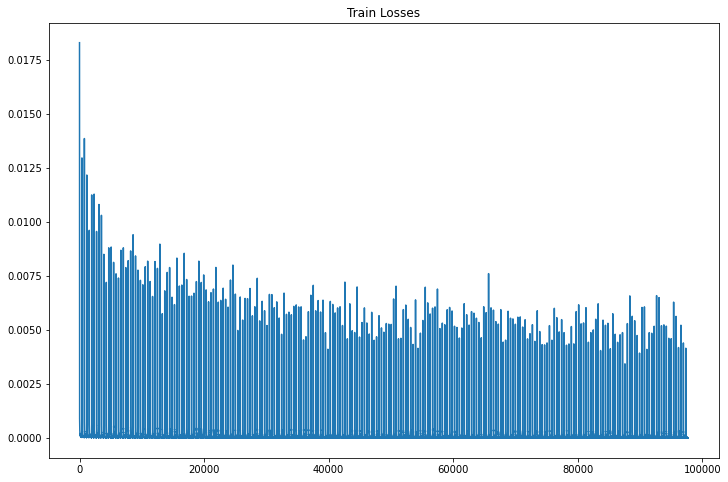

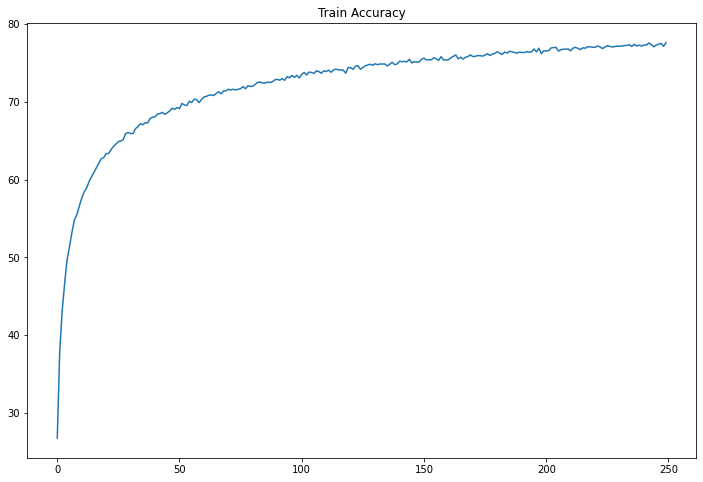

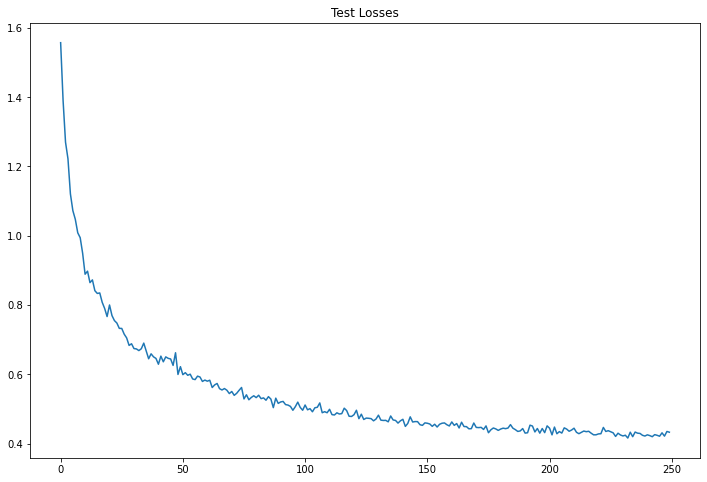

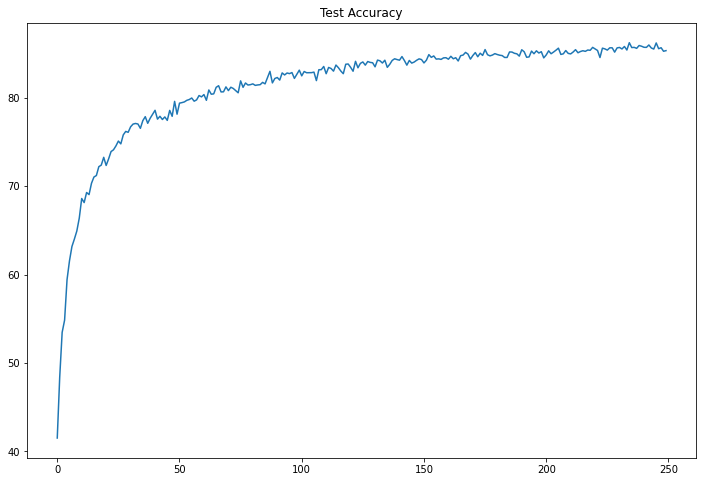

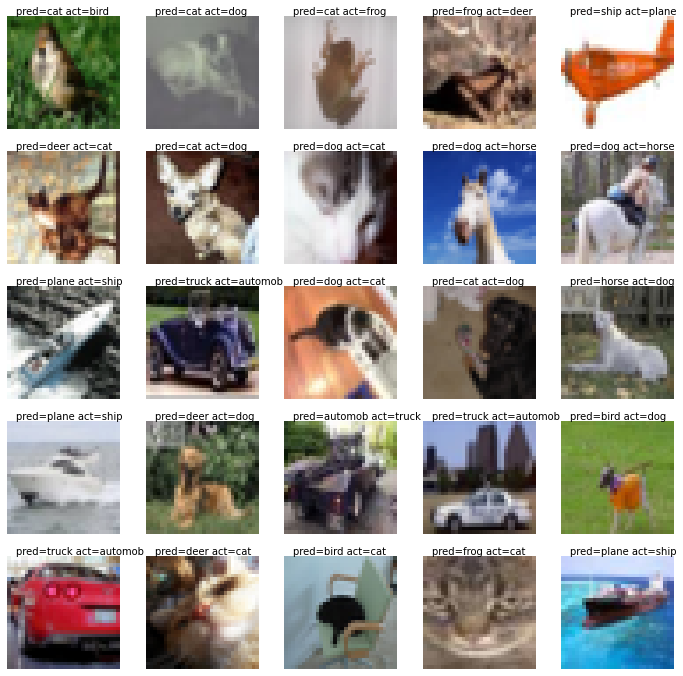

In [17]:
EPOCHS = 250
model = s7_model.S7_CNNModel_mixed().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.8, weight_decay = 0)
scheduler = OneCycleLR(optimizer, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=EPOCHS)
stats = utilities.ctr()
train = train_loss.train_losses(model, device, trainloader, stats, optimizer, EPOCHS)
test  = test_loss.test_losses(model, device, testloader, stats, EPOCHS)

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch}')
    train.s7_train(epoch, L1_factor=0.0005)
    test.s7_test(epoch)  

global details
details = utilities.counters
disp_details()